# Generator neural network

This file contains the core functionality needed to be implemented.

**Goal:** Have a neural network, that given an image $X \in \mathcal{I}$ outputs another image $Y = G(X;\theta_g) \in \mathcal{I}$ such that a difference $d_S(X,Y)$ is maximized while keeping the embedding difference $d_E(\mathcal{E}(X),\mathcal{E}(Y))$ as small as possible.

## Step 1. Load the MNIST dataset

In [1]:
import random

import tensorflow as tf
import numpy as np

import sklearn
from sklearn.decomposition import PCA

from keras.datasets import mnist
from matplotlib import pyplot
from mpl_toolkits import mplot3d

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = tf.expand_dims(X_train, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)

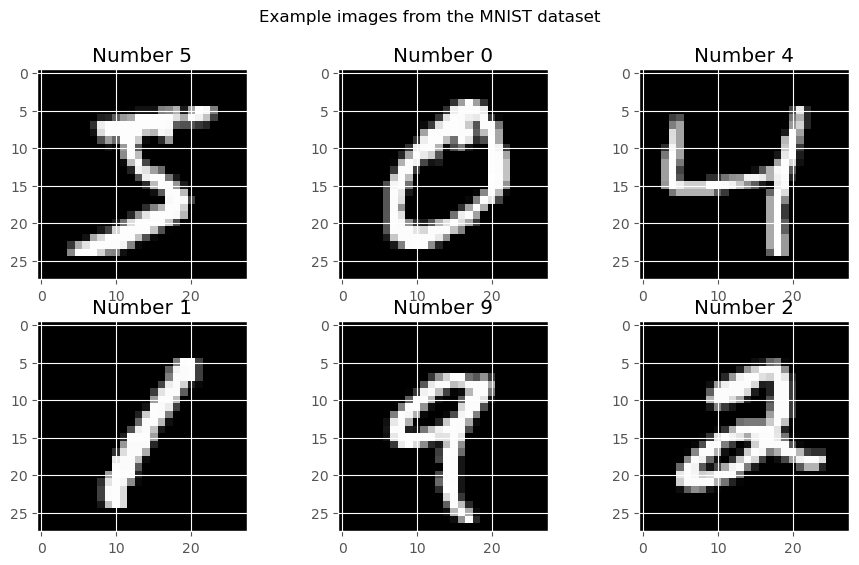

In [3]:
pyplot.style.use('ggplot')

fig, axs = pyplot.subplots(nrows=2, ncols=3, figsize=(11,6))
for i, ax in enumerate(axs.flatten()):
    pyplot.sca(ax)
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
    pyplot.title(f'Number {y_train[i]}')

pyplot.suptitle('Example images from the MNIST dataset')
pyplot.show()

## Step 2. Load embedding model

In [4]:
MODEL_PATH = 'models/embedding/embedding_v2'
embedding_model = tf.keras.models.load_model(MODEL_PATH)
embedding_model._name = 'embedding'
embedding_model.trainable = False
embedding_model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden_layer (Dense)        (None, 2048)              1607680   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2048)              0         
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
 unit_normalization (UnitNor  (None, 10)               0         
 malization)                                                     
                                                                 
Total params: 1,628,170
Trainable params: 0
Non-trainable params: 1,628,170
_______________________________________________

Just testing a performance of an embedding model:

In [5]:
X_ones = [X for X, y in zip(X_test, y_test) if y == 1]
X_twos = [X for X, y in zip(X_test, y_test) if y == 2]

prediction_ones = embedding_model.predict(np.array(X_ones, dtype=np.float32), verbose=0)
prediction_twos = embedding_model.predict(np.array(X_twos, dtype=np.float32), verbose=0)

EXAMPLE_PREDICTIONS_NUM = 5

print('-- Distances for numbers 1: --')
for prediction in prediction_ones[:EXAMPLE_PREDICTIONS_NUM]:
    print(prediction)
    
print('-- Predictions for numbers 2: --')
for prediction in prediction_twos[:EXAMPLE_PREDICTIONS_NUM]:
    print(prediction)

2023-11-06 18:34:36.760766: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


-- Distances for numbers 1: --
[ 0.14256765 -0.34618497 -0.1108418  -0.08441032 -0.09383458  0.18363273
 -0.27000797  0.60559416  0.33755812  0.4942668 ]
[ 0.0996884  -0.25877544 -0.13275488 -0.14228745 -0.1004504   0.11080812
 -0.24827822  0.69680727  0.29428348  0.47861663]
[ 0.0881075  -0.36256605 -0.07923913 -0.07146174 -0.06686427  0.22159867
 -0.21514383  0.65145683  0.31473887  0.4754756 ]
[ 0.05684978 -0.37826777 -0.11702026 -0.08197065 -0.09425713  0.20853606
 -0.21576416  0.6543819   0.37512013  0.40670872]
[ 0.05102295 -0.31556058 -0.07578187 -0.0715683  -0.08305446  0.13836403
 -0.21518414  0.6823655   0.3297057   0.49018145]
-- Predictions for numbers 2: --
[ 0.15439235 -0.33761686 -0.39058384  0.07263189  0.42708275  0.17502111
 -0.22533473 -0.63930696  0.14473015 -0.10430182]
[-0.05799386 -0.35643557 -0.4658165   0.01458859  0.43040404  0.22522584
 -0.28410104 -0.5603529   0.12468364 -0.07850693]
[-0.19010422 -0.5390893  -0.13540742  0.3681959   0.29021218  0.36690357
  

## Step 3. Defining a generator model

In [6]:
def Unet(input_shape=(28, 28, 1)):
    """
    Generates a generator that inputs an image and returns yet another image
    """
    
    # Define the input layer
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder (contracting path)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(conv3)

    # Decoder (expansive path)
    up4 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = tf.keras.layers.concatenate([up4, conv2], axis=3)
    conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(up4)
    conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(conv4)

    up5 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = tf.keras.layers.concatenate([up5, conv1], axis=3)
    conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(up5)
    conv5 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=tf.keras.initializers.HeUniform())(conv5)

    # Output layer
    output_image = tf.keras.layers.Conv2D(1, 1, activation='sigmoid', name='output_image')(conv5)
    
    # Returning a retrieved model
    model = tf.keras.models.Model(inputs=inputs, outputs=output_image, name='generator')
    return model

# Instantiate the model
generator = Unet()

# Display the model summary
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 64)   640         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 64)   0           ['conv2d_1[0][0]']               
                                                                                          

1/1 [==============================] - 0s 70ms/step


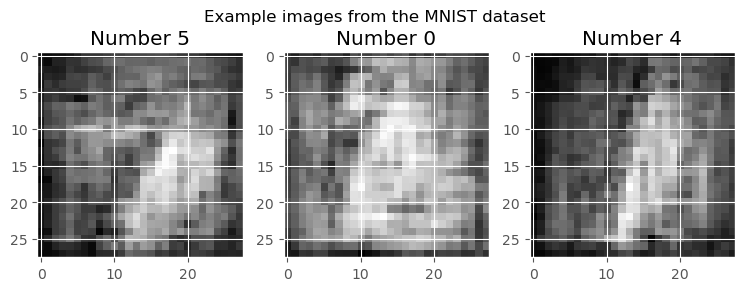

In [7]:
pyplot.style.use('ggplot')

generator_predictions = generator.predict(X_test[:3])
fig, axs = pyplot.subplots(nrows=1, ncols=3, figsize=(9,3))
for i, ax in enumerate(axs.flatten()):
    pyplot.sca(ax)
    pyplot.imshow(generator_predictions[i], cmap=pyplot.get_cmap('gray'))
    pyplot.title(f'Number {y_train[i]}')

pyplot.suptitle('Example images from the MNIST dataset')
pyplot.show()

In [8]:
def Trainer(generator, embedding_model, input_shape=(28, 28, 1)):
    # Define the input layer
    img_input = tf.keras.layers.Input(input_shape, name='image_input')

    # Define the output image from the generator
    output_image = generator(img_input)
    output_image._name = 'generated_image'

    # Embedding layer applied to the generated image
    embedding_generated = embedding_model(output_image)
    embedding_generated._name = 'generated_embedding'
    
    # Build a model
    model = tf.keras.models.Model(inputs=img_input, outputs=[output_image, embedding_generated])    
    return model

# Instantiate the model
trainer = Trainer(generator, embedding_model)

# Display the model summary
trainer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 generator (Functional)      (None, 28, 28, 1)         1881985   
                                                                 
 embedding (Sequential)      (None, 10)                1628170   
                                                                 
Total params: 3,510,155
Trainable params: 1,881,985
Non-trainable params: 1,628,170
_________________________________________________________________


## Step 4. Launching the training session

Forming the dataset:

In [9]:
embeddings_train = embedding_model.predict(np.array(X_train, dtype=np.float32), verbose=0)
y_train_merged = [X_train, embeddings_train]

Defining hyperparameters used for training:

In [10]:
hyperparams = {
    # Loss function parameters
    "threshold": 0.0,
    "lambda_img": -0.1,
    "lambda_emb": 1.0,
    # Training parameters
    "learning_rate": 1e-4,
    "epochs": 2,
    "batch_size": 64,
    "validation_split": 0.2
}

Defining the loss function

In [11]:
def SSIMLoss(y_true: any, y_pred: any) -> float:
    """
    Loss function for image comparison
    """
    return hyperparams['lambda_img'] * (1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0, filter_size=7))) / 2.0

def MSEImageLoss(y_true: any, y_pred: any) -> float:
    """
    Loss function for image comparison
    """
    return hyperparams['lambda_img'] * tf.reduce_mean(tf.math.square(y_true - y_pred))

def ThresholdLoss(y_true: any, y_pred: any) -> float:
    """
    Loss function for embedded vectors comparison
    """
    differences = tf.math.reduce_sum(tf.math.square(y_true - y_pred), axis=1)
    differences = tf.nn.relu(differences - hyperparams['threshold'])
    return hyperparams['lambda_emb'] * tf.reduce_mean(differences) / 4.0

Testing losses on example batches:

In [12]:
# SSIM Loss testing
X_zeros = np.array([X for X, y in zip(X_test, y_test) if y == 0], dtype=np.float32)
X_ones = np.array([X for X, y in zip(X_test, y_test) if y == 1], dtype=np.float32)
print(f'Loss between different digits: {SSIMLoss(X_zeros[:32], X_ones[:32])}')
print(f'Loss between images of digit 0: {SSIMLoss(X_zeros[:32], X_zeros[32:64])}')
print(f'Loss between images of digit 1: {SSIMLoss(X_ones[:32], X_ones[32:64])}')

Loss between different digits: -0.043399423360824585
Loss between images of digit 0: -0.03682649880647659
Loss between images of digit 1: -0.018602633848786354


In [13]:
# MSE Loss testing
X_zeros = np.array([X for X, y in zip(X_test, y_test) if y == 0], dtype=np.float32)
X_ones = np.array([X for X, y in zip(X_test, y_test) if y == 1], dtype=np.float32)
print(f'Loss between different digits: {MSEImageLoss(X_zeros[:32], X_ones[:32])}')
print(f'Loss between images of digit 0: {MSEImageLoss(X_zeros[:32], X_zeros[32:64])}')
print(f'Loss between images of digit 1: {MSEImageLoss(X_ones[:32], X_ones[32:64])}')

Loss between different digits: -0.01570349745452404
Loss between images of digit 0: -0.012416738085448742
Loss between images of digit 1: -0.004519284702837467


Defining the loss functions:

In [15]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=hyperparams['learning_rate'])
trainer.compile(optimizer=optimizer, loss={
    'generator': MSEImageLoss,
    'embedding': ThresholdLoss
})

In [16]:
trainer.fit(
    X_train,
    y_train_merged,
    batch_size=hyperparams['batch_size'],
    epochs=hyperparams['epochs'],
    validation_split=hyperparams['validation_split'],
    verbose=1
)

Epoch 1/2
750/750 [==============================] - 375s 499ms/step - loss: 0.1630 - generator_loss: -0.0412 - embedding_loss: 0.0114 - val_loss: 0.1500 - val_generator_loss: -0.0505 - val_embedding_loss: 0.0076
Epoch 2/2
750/750 [==============================] - 375s 500ms/step - loss: 0.1460 - generator_loss: -0.0567 - embedding_loss: 0.0099 - val_loss: 0.1428 - val_generator_loss: -0.0630 - val_embedding_loss: 0.0130


1/1 [==============================] - 0s 27ms/step


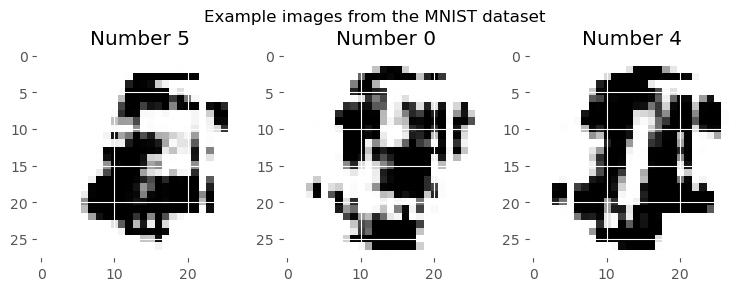

In [17]:
pyplot.style.use('ggplot')

generator_predictions = generator.predict(X_test[:3])
fig, axs = pyplot.subplots(nrows=1, ncols=3, figsize=(9,3))
for i, ax in enumerate(axs.flatten()):
    pyplot.sca(ax)
    pyplot.imshow(generator_predictions[i], cmap=pyplot.get_cmap('gray'))
    pyplot.title(f'Number {y_train[i]}')

pyplot.suptitle('Example images from the MNIST dataset')
pyplot.show()

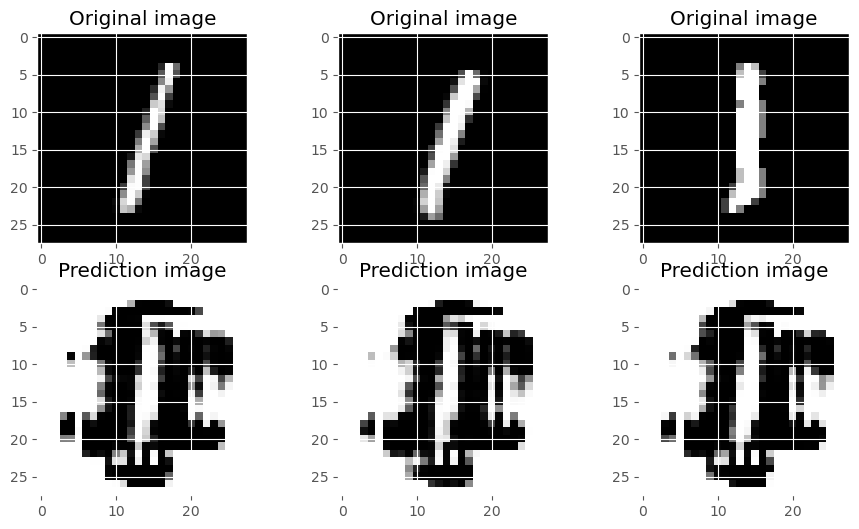

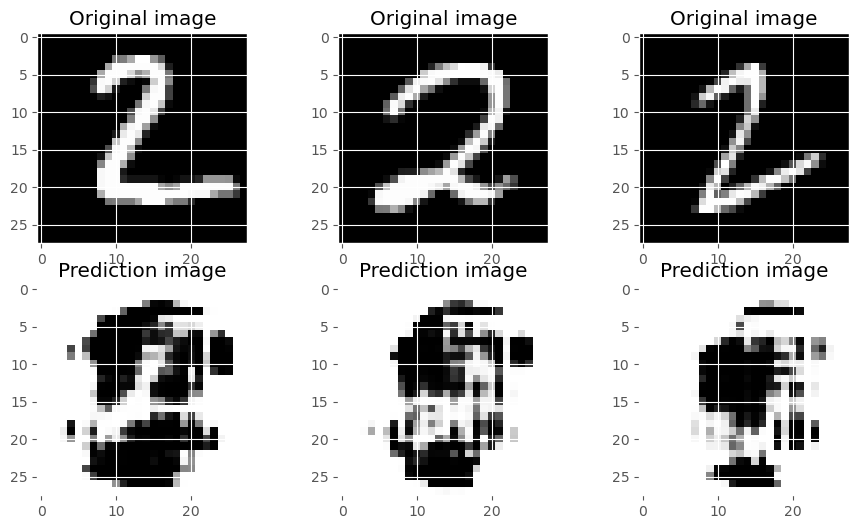

In [18]:
X_ones = [X for X, y in zip(X_test, y_test) if y == 1]
X_twos = [X for X, y in zip(X_test, y_test) if y == 2]

prediction_ones = generator.predict(np.array(X_ones, dtype=np.float32), verbose=0)
prediction_twos = generator.predict(np.array(X_twos, dtype=np.float32), verbose=0)

fig, axs = pyplot.subplots(nrows=2, ncols=3, figsize=(11,6))
for i, ax in enumerate(axs.flatten()):
    pyplot.sca(ax)
    if i < 3:
        pyplot.imshow(X_ones[i], cmap=pyplot.get_cmap('gray'))
        pyplot.title(f'Original image')
    else:
        pyplot.imshow(prediction_ones[i], cmap=pyplot.get_cmap('gray'))
        pyplot.title(f'Prediction image')
        
fig, axs = pyplot.subplots(nrows=2, ncols=3, figsize=(11,6))
for i, ax in enumerate(axs.flatten()):
    pyplot.sca(ax)
    if i < 3:
        pyplot.imshow(X_twos[i], cmap=pyplot.get_cmap('gray'))
        pyplot.title(f'Original image')
    else:
        pyplot.imshow(prediction_twos[i], cmap=pyplot.get_cmap('gray'))
        pyplot.title(f'Prediction image')

In [ ]:
embedding_prediction_ones = embedding_model.predict(np.array(X_ones, dtype=np.float32), verbose=0)
embedding_prediction_twos = embedding_model.predict(np.array(X_twos, dtype=np.float32), verbose=0)

embedding_prediction_ones_generated = embedding_model.predict(np.array(prediction_ones, dtype=np.float32), verbose=0)
embedding_prediction_twos_generated = embedding_model.predict(np.array(prediction_twos, dtype=np.float32), verbose=0)

print('--Distance original-generated ones:--')
for i in range(6):
    print(tf.norm(embedding_prediction_ones[i] - embedding_prediction_ones_generated[i], ord='euclidean')**2)

print('--Distance generated-generated ones:--')
for i in range(6):
    print(tf.norm(embedding_prediction_ones_generated[i] - embedding_prediction_ones_generated[i+10], ord='euclidean')**2)

print('--Distance generated one - generated two:--')
for i in range(6):
    print(tf.norm(embedding_prediction_ones_generated[i] - embedding_prediction_twos_generated[i], ord='euclidean')**2)

In [ ]:
generator.save('models/generator/v4')